<a href="https://colab.research.google.com/github/joshuajhchoi/Real-Time-Voice-Cloning/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wasserstein GAN

[WGAN](https://arxiv.org/abs/1701.07875) is an important version of GANs. It's based on the Earthmover distance distance which is an optimization problem that solve transportation problem.

GAN duty is to learn a probability distribution, but it's job become harder if we are dealing with distributions supported by low dimensional manifolds. It is then unlikely that the model manifold and the true distribution’s support have a non-negligible intersection.

The solution is to treat each point in the noise as a discret probability distribution and then calculate the Euclidean distance between the fake point and real point in the real data distribution. The objective is to minimize the cost of the sum of the distance between points in real and fake data distribution. With Earthmover distance, we get point-by-point details about how each data point affects the output. This kind of attention to detail is very important in our situation.


![Curve%20%281%29.png](https://drive.google.com/uc?export=view&id=1sbi6BrTLGHh7SW8eS7Pl3rY85uoZ6jyY)
![Neuro.png](https://drive.google.com/uc?export=view&id=1TR7r_TOyVFI-era4qr98E7HF7ifvpeMQ)

The diffrence between GAN and WGAN is that the discriminator predicts the probability of a generated image being “real” and the critic model scores the “realness” of a given image.

[click for more ressources](https://jeremykun.com/2018/03/05/earthmover-distance/)

### Learning Objectives

- Learn how to train WGAN 
- Learning the implementation details for WGAN
- Knowing the diffrence between a discriminator predicting a probability and a critic predicting a score

### Practical steps we will follow

1. Explore data and prepare the dataset for training
3. Define and Implement the Generator and the discriminator Network Architecture
4. Work on the training/ evaluation loop and generate new realistic samples using WGAN



### Steps to run this notebook from Colaboratory

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.

### Imports (RUN ME!)

Make sure to run the imports cell above, otherwise the rest of the cells will fail when you try to run them. (To run a cell press `shift` + `enter` with your mouse cursor in the cell or press the play button in the top right of the cell.)

In [ ]:
%load_ext tensorboard

import os
from glob import glob
import time
import random

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import imageio
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal
%matplotlib inline

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configs

In [ ]:
# Experiment paths
# Save the model for further use
EXPERIMENT_ID = "train_wgan"
MODEL_SAVE_PATH = os.path.join("/content/drive/My Drive/lecture hands on lab/wgan/results", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')


# Data path
DATA_PATH =  "/content/drive/My Drive/lecture hands on lab/datasets/cars/cars_images/"


# Model parameter
BATCH_SIZE = 64
EPOCHS = 9000
LATENT_DEPTH = 100
IMAGE_SHAPE = [100,100]
NB_CHANNELS = 3
LR = 1e-4
BETA = 0.5
NOISE = tf.random.normal([1, LATENT_DEPTH])


# Parameters for THE CRITIC
N_CRITIC = 5
CLIPPING_WEIGHT = 0.01


# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved.
seed = random.seed(30)

### Data understanding and exploration

We will be using the same dataset [cars dataset](https://www.kaggle.com/prondeau/the-car-connection-picture-dataset) as  DCGAN to see the diffrence more clearly.

In [ ]:
image_count = len(list(glob(str( DATA_PATH + '*.jpg'))))
image_count

8960

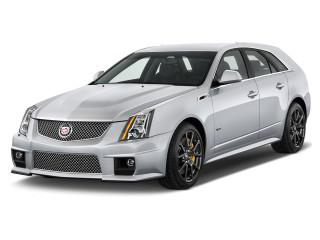

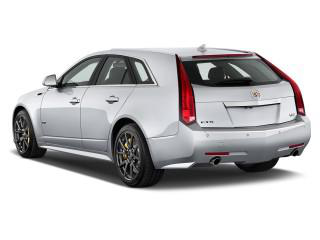

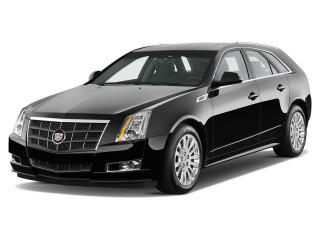

In [ ]:
cars_images_path = list(glob(str(DATA_PATH + '*.jpg')))
for image_path in cars_images_path[:3]:
    display.display(Image.open(str(image_path)))

In [ ]:
# Our goal to get images filenames
images_name = [i.split(DATA_PATH) for i in cars_images_path]
images_name = [x[:][1] for x in images_name]
cars_model = [i.split('_')[0] for i in images_name]

In [ ]:
# Extract cars models
def unique(list1): 
    list_set = set(list1) 
    unique_list = (list(list_set)) 
    return unique_list

In [ ]:
unique_cars = unique(cars_model)
unique_cars

['Subaru',
 'Rolls-Royce',
 'Aston Martin',
 'Volkswagen',
 'Chevrolet',
 'Porsche',
 'BMW',
 'Audi',
 'Chrysler',
 'Toyota',
 'Ram',
 'Buick',
 'Bentley',
 'Cadillac',
 'Alfa Romeo',
 'Tesla',
 'smart',
 'Acura',
 'Volvo',
 'Nissan']

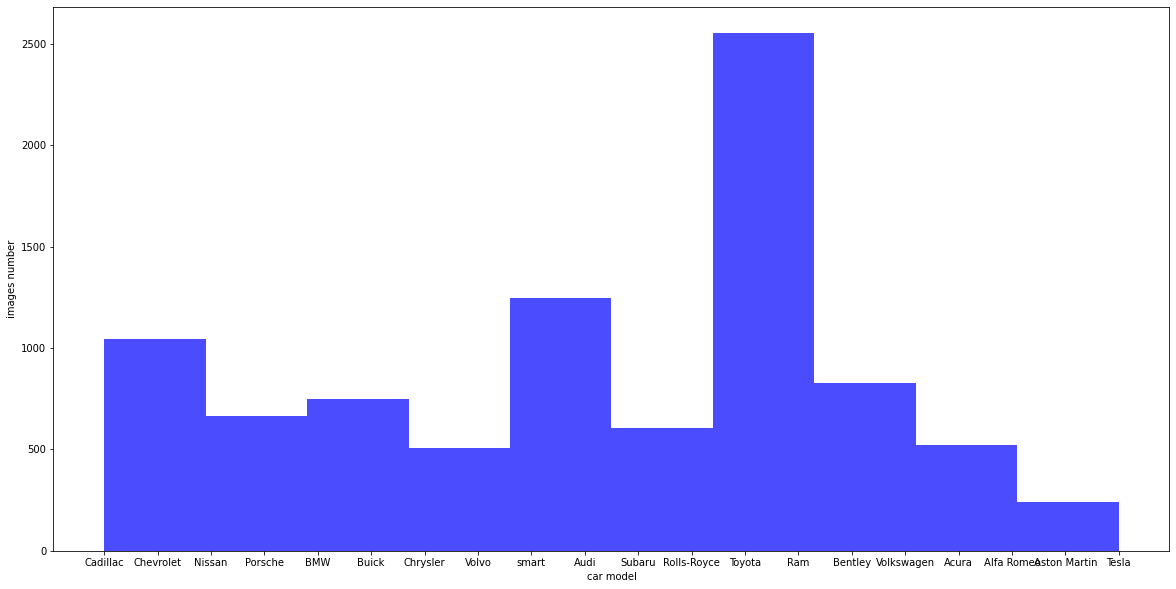

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(cars_model, color = "blue", lw=0, alpha=0.7)
plt.ylabel('images number')
plt.xlabel('car model')
plt.show()

In [ ]:
image_size = []
for filename in cars_images_path:
    im=Image.open(filename)
    im =im.size
    image_size.append(im)
print(max(image_size))
print(min(image_size))

In [ ]:
# Read in the image
image = mpimg.imread(cars_images_path[20])

plt.axis("off")
plt.imshow(image)

In [ ]:
# Isolate RGB channels
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('R channel')
ax1.imshow(r, cmap='gray')
ax2.set_title('G channel')
ax2.imshow(g, cmap='gray')
ax3.set_title('B channel')
ax3.imshow(b, cmap='gray')

The dataset contains 8960 images:
* Three-channel each one.
* Diverse styles
* the minimum shape is (320, 124)
* the maximum shape is (320, 360)

### Data Loader

For the Data pipeline, we will be using Data API provide it by TensorFlow. What we have to do is create a dataset object, tell it where to get the data, then transform it in any way we want, and TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, prefetching, and so on.\
(1) Create dataset entirely in RAM using tf.data.Dataset.from_tensor_slices() \
(2) Call shuffle to ensure that the training set are independent and identically distributed. \
NB:  the buffer size must be specified, and it is important to make it large enough or else shuffling will not be very efficient.\
(3) Do the necessary transformation by calling the map() method. \
(4) Call the batch() method. It will group the items of the previous dataset in batches of n items. \
(5) Using prefetch will let the dataset work on parallel with training algorithm to get the next batch ready.
![alt text](https://drive.google.com/uc?export=view&id=1xe7O6sTg1HxbM_Fc8p57gGXB9keeaDjC)


We must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [-1,1] or [0,1]. But you should know that if you're using [-1,1] you need to choose tanh as an activation function and if you are normalizing to [0,1] you use sigmoid activation function.

### Data Loader using TF API

In [ ]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image

In [ ]:
def dataloader(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.map(preprocessing_data)
    dataset = dataset.batch(10* BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
dataset = dataloader(cars_images_path)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

# Modeling

![Critic%201-2.png](https://drive.google.com/uc?export=view&id=1TuQulD29Mq7pzvqxg_cbwpcSd6eDnJkX)

The differences in implementation for the WGAN and DCGAN are as follows:

1. Adding a linear activation function in the output layer of the critic model or remove sigmoid function if you're using it.

2. Use Wasserstein loss to train the critic and generator models that promote larger difference between scores for real and generated images.
3. Adding a constraint to limit the weight range after each mini batch update (e.g. [-0.01,0.01] like the paper).
4. Update the critic model more times than the generator each iteration (e.g. 5 like the paper).
5. Use the RMSProp version of gradient descent with small learning rate and no momentum (e.g. 0.00005 like the paper).

Recommandation: Use always the paper hyperparameter to get a baseline model and then built on it the changes

### Generator

The generator model is responsible for creating new, fake, but plausible small photographs of objects.
It does this by taking a point from the latent space as input and outputting a square color image and this will not change in WGAN.
![Generator.png](https://drive.google.com/uc?export=view&id=1R14EtpJXZo_kKWJSsUqUPPdLgZ_phMhV)

In [ ]:
def make_generator_model():
    #weight initialization
    #init = RandomNormal(stddev=0.02)
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*128, use_bias=False, input_shape=(100,))) # add kernel_initializer=init in case of weight initialization
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((25, 25, 128)))
    assert model.output_shape == (None, 25, 25, 128) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))# add kernel_initializer=init in case of weight initialization
    assert model.output_shape == (None, 25, 25, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))# add kernel_initializer=init in case of weight initialization
    assert model.output_shape == (None, 50, 50, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))# add kernel_initializer=init in case of weight initialization
    assert model.output_shape == (None, 100, 100, 3)
    model.summary()
    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80000)             8000000   
_________________________________________________________________
batch_normalization_9 (Batch (None, 80000)             320000    
_________________________________________________________________
re_lu_9 (ReLU)               (None, 80000)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 25, 25, 128)       409600    
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 25, 128)       512       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 25, 25, 128)      

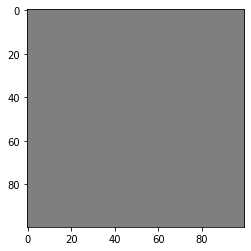

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=True)

plt.imshow(generated_image[0, :, :, :], cmap='gray')

### Critic

The model must take a sample image from our dataset as input and ~~output a classification prediction as to whether the sample is real or fake. This is a binary classification problem.~~ output scores for real and generated images.

- Inputs: Image with three color channel and 100×100 pixels in size.
- Outputs: ~~Binary classification, likelihood the sample is real (or fake).~~
- Outputs: scores for real and generated images.

![Critic.png](https://drive.google.com/uc?export=view&id=119XxKIM-0FDENKupTwPw1qprC3mo-LQX)

In [ ]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[100, 100, 3]))
    model.add(layers.ReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) #activation='linear'
    model.summary()
    return model

In [ ]:
critic = make_critic_model()
decision = critic(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        4864      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)            

## Loss and Optimization

~~cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)~~

The Wasserstein GAN uses the 1-Wasserstein distance, rather than the JS-Divergence, to measure the difference between the model and target distributions.

In [ ]:
def critic_loss(r_logit, f_logit):
    real_loss = - tf.reduce_mean(r_logit)
    fake_loss = tf.reduce_mean(f_logit)
    return real_loss, fake_loss

def generator_loss(f_logit):
    fake_loss = - tf.reduce_mean(f_logit)
    return fake_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate= LR) #tf.keras.optimizers.RMSprop(learning_rate= LR)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate= LR) #tf.keras.optimizers.RMSprop(learning_rate= LR)


## Experiment utils (RUN ME!)

In [ ]:
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram', 'image'],
            historgram_buckets=None,
            name='summary'):
    """Summary.
    Examples
    --------
    >>> summary({'a': data_a, 'b': data_b})
    """
    def _summary(name, data):
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)
            if 'image' in types:
                tf.summary.image(name, data, step=step)

    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)

In [ ]:
train_summary_writer = tf.summary.create_file_writer(os.path.join(MODEL_SAVE_PATH, 'summaries', 'train'))
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=critic_optimizer,
                                 generator=generator,
                                 discriminator=critic)

In [ ]:
def generate_and_save_images(model, epoch, noise):
    
    plt.figure(figsize=(15,10))

    for i in range(4):
        images = model(noise, training=False)
        
        image = images[0, :, :, :]
        image = np.reshape(image, [100, 100, 3])
        
        plt.subplot(1, 4, i+1)
        plt.imshow(np.uint8(image), cmap='gray')
        plt.axis('off')
        plt.title("Randomly Generated Images")

    plt.tight_layout()  
    plt.savefig(os.path.join(MODEL_SAVE_PATH,'image_at_epoch_{:02d}.png'.format(epoch)))
    plt.show()

## Training Process

In [ ]:
@tf.function
def train_generator(noise):
    with tf.GradientTape() as tape:
        # create fake image
        generated_images = generator(noise, training=True)

        fake_logit = critic(generated_images, training=True)
        # calculate generator loss
        g_loss = generator_loss(fake_logit)

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    return {'Generator loss': g_loss}

In [ ]:
@tf.function
def train_Critic(noise, real_img):
    with tf.GradientTape() as t:
        fake_img = generator(noise, training=True)

        real_logit = critic(real_img, training=True)
        fake_logit = critic(fake_img, training=True)

        real_loss, fake_loss = critic_loss(real_logit, fake_logit)
        d_loss = (real_loss + fake_loss)

    D_grad = t.gradient(d_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(D_grad, critic.trainable_variables))
    for w in critic.trainable_variables:
        w.assign(tf.clip_by_value(w, -CLIPPING_WEIGHT, CLIPPING_WEIGHT))
    return {'Critic loss': real_loss + fake_loss}

In [ ]:
def train(dataset, epochs):
    with train_summary_writer.as_default():
        with tf.summary.record_if(True):
            for epoch in range(epochs):
                start = time.time()
                for image_batch in dataset:
                    C_loss_dict = train_Critic(NOISE, image_batch)

                summary(C_loss_dict, step=critic_optimizer.iterations, name='critic_losses')
                
                if critic_optimizer.iterations.numpy() % N_CRITIC == 0:
                    G_loss_dict = train_generator(NOISE)
                    summary(G_loss_dict, step=generator_optimizer.iterations, name='generator_losses')
                    
                display.clear_output(wait=True)
                generate_and_save_images(generator,
                                         epoch + 1, NOISE)
                
                if (epoch + 1) % 15 == 0:
                    checkpoint.save(file_prefix = checkpoint_prefix)

                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, NOISE)

In [ ]:
train(dataset, EPOCHS)

In [ ]:
%tensorboard --logdir='/content/drive/My Drive/lecture hands on lab/wgan/results/summaries'

### Generate Gif with the whole generated images during training

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

### Congratulations!
you have built your first WGAN

### What's expected from you

* Play arround with optimizer
* Tuning the model
* Observe the critic and generator loss failure and image generation failure using tensorboard
* Add L2 regularization

### Extra Reading :
* https://paper.dropbox.com/doc/Wasserstein-GAN-GvU0p2V9ThzdwY3BbhoP7
* https://arxiv.org/pdf/1803.00567.pdf
* https://www.youtube.com/watch?v=SZHumKEhgtA
* https://mindcodec.ai/2018/09/19/an-intuitive-guide-to-optimal-transport-part-i-formulating-the-problem/
* https://vincentherrmann.github.io/blog/wasserstein/
* https://mindcodec.ai/2018/09/23/an-intuitive-guide-to-optimal-transport-part-ii-the-wasserstein-gan-made-easy/